In [8]:
import tensorflow as tf
import cv2
import numpy as np
import os
from pathlib import Path
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import json
print("TensorFlow version:", tf.__version__)
print("All imports successful!")

TensorFlow version: 2.19.0
All imports successful!


In [5]:
import cv2
import numpy as np
import os
from pathlib import Path
import json

class FaceDataCollector:
    def __init__(self, data_dir='face_data', img_size=(92, 112)):
        self.data_dir = Path(data_dir)
        self.data_dir.mkdir(exist_ok=True)
        self.img_size = img_size
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )
        self.person_details = {}

    def collect_face_data(self, person_id, person_data, num_images=10):
        """Collect face data and store person details"""
        self.person_details[person_id] = person_data
        person_dir = self.data_dir / f"person_{person_id}"
        person_dir.mkdir(exist_ok=True)
        
        cap = cv2.VideoCapture(0)
        images_collected = 0
        
        while images_collected < num_images:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break
                
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = self.face_cascade.detectMultiScale(
                gray, 
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30)
            )
            
            for (x, y, w, h) in faces:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            cv2.putText(frame, f"Collecting for {person_data['name']}: {images_collected}/{num_images}", 
                        (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('Collecting Face Data', frame)
            
            key = cv2.waitKey(1)
            if key == ord('c') and len(faces) == 1:
                x, y, w, h = faces[0]
                face = gray[y:y+h, x:x+w]
                face = cv2.resize(face, self.img_size)
                
                cv2.imwrite(
                    str(person_dir / f"face_{images_collected}.jpg"),
                    face
                )
                images_collected += 1
                
            elif key == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()

    def create_npz_dataset(self):
        """Create NPZ file from collected images"""
        images = []
        labels = []
        
        for person_dir in self.data_dir.glob("person_*"):
            person_id = int(person_dir.name.split('_')[1])
            
            for img_path in person_dir.glob("face_*.jpg"):
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                images.append(img)
                labels.append(person_id)
        
        X = np.array(images)
        y = np.array(labels)
        
        indices = np.random.permutation(len(X))
        split_idx = int(len(X) * 0.8)
        
        train_indices = indices[:split_idx]
        test_indices = indices[split_idx:]
        
        trainX = X[train_indices]
        trainY = y[train_indices]
        testX = X[test_indices]
        testY = y[test_indices]
        
        np.savez('face_dataset.npz',
                 trainX=trainX,
                 trainY=trainY,
                 testX=testX,
                 testY=testY)
        
        # Save person details (including roll number, name, etc.)
        with open('person_details.json', 'w') as f:
            json.dump(self.person_details, f, indent=4)
        
        print(f"Dataset created with {len(trainX)} training and {len(testX)} testing images")
        return 'face_dataset.npz'

In [6]:

# Create collector instance
collector = FaceDataCollector()

# Get input from user
num_people = int(input("Enter number of people to collect data for: "))
images_per_person = int(input("Enter number of images per person (recommend 20): "))

# Collect data for each person
for person_id in range(num_people):
    print(f"\nRegistering Person {person_id + 1}:")
    
    roll_number = input("Enter Roll Number: ")
    name = input("Enter Name: ")
    year = input("Enter Year: ")
    branch = input("Enter Branch: ")
    section = input("Enter Section: ")
    
    person_data = {
        "roll_number": roll_number,
        "name": name,
        "year": year,
        "branch": branch,
        "section": section
    }
    
    print(f"\nCollecting data for {name} (Roll No: {roll_number})")
    print("Press 'c' to capture an image when face is detected")
    print("Press 'q' to finish collection for this person")
    
    collector.collect_face_data(person_id, person_data, images_per_person)

# Create dataset
npz_file = collector.create_npz_dataset()
print(f"Dataset saved as: {npz_file}")

Enter number of people to collect data for:  4
Enter number of images per person (recommend 20):  200



Registering Person 1:


Enter Roll Number:  220101087
Enter Name:  S. Sai Yashwanth
Enter Year:  3
Enter Branch:  CSE
Enter Section:  B



Press 'c' to capture an image when face is detected
Press 'q' to finish collection for this person

Registering Person 2:


Enter Roll Number:  220101026
Enter Name:  V. Lohith
Enter Year:  3
Enter Branch:  CSE
Enter Section:  A



Press 'c' to capture an image when face is detected
Press 'q' to finish collection for this person

Registering Person 3:


Enter Roll Number:  220101091
Enter Name:  M. Santosh
Enter Year:  3
Enter Branch:  CSE
Enter Section:  B



Press 'c' to capture an image when face is detected
Press 'q' to finish collection for this person

Registering Person 4:


Enter Roll Number:  220103002
Enter Name:  K. Gagan
Enter Year:  3
Enter Branch:  CSE-AI
Enter Section:  B



Press 'c' to capture an image when face is detected
Press 'q' to finish collection for this person
Dataset created with 640 training and 160 testing images
Dataset saved as: face_dataset.npz



Registering Person 1:


Enter Roll Number:  1087
Enter Name:  Yashwanth
Enter Year:  3
Enter Branch:  CSE
Enter Section:  B



Press 'c' to capture an image when face is detected
Press 'q' to finish collection for this person

Registering Person 2:


Enter Roll Number:  1026
Enter Name:  Lohith
Enter Year:  3
Enter Branch:  CSE
Enter Section:  A



Press 'c' to capture an image when face is detected
Press 'q' to finish collection for this person
Dataset created with 80 training and 20 testing images
Dataset saved as: face_dataset.npz


In [7]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load dataset
data = np.load('face_dataset.npz')

x_train = data['trainX']
y_train = data['trainY']
x_test = data['testX']
y_test = data['testY']

# Convert labels to integer type
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)


# Reshape to add channel dimension (CNN expects (height, width, channels))
x_train = x_train.reshape(-1, 112, 92, 1) / 255.0  # Normalize to [0,1]
x_test = x_test.reshape(-1, 112, 92, 1) / 255.0    # Normalize to [0,1]

# Load person details
with open('person_details.json', 'r') as f:
    person_details = json.load(f)

# Number of unique classes (each person is a class)
num_classes = len(person_details)

print(f"Training model with {num_classes} unique persons.")

def create_model(num_classes):
    model = Sequential([
        Input(shape=(112, 92, 1)),  # Explicit Input layer to avoid warning

        # First Convolutional Block
        Conv2D(32, kernel_size=3, activation='relu', padding='same'),
        Conv2D(32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=2),

        # Second Convolutional Block
        Conv2D(64, kernel_size=3, activation='relu', padding='same'),
        Conv2D(64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=2),

        # Third Convolutional Block
        Conv2D(128, kernel_size=3, activation='relu', padding='same'),
        Conv2D(128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')  # Output neurons match number of persons
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create model
model = create_model(num_classes)

# Define Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=40,  # Increased patience for longer training
    restore_best_weights=True,
    verbose=1
)

# Train model
history = model.fit(
    x_train, y_train,
    batch_size=16,  
    epochs=100,     
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Save model
model.save('face_recognition_model.h5')
print("Model saved as 'face_recognition_model.h5'")

# Save person details mapping for later identification
with open('trained_person_details.json', 'w') as f:
    json.dump(person_details, f, indent=4)

print("Person details mapping saved as 'trained_person_details.json'")


Training model with 4 unique persons.
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 516ms/step - accuracy: 0.2611 - loss: 1.5505 - val_accuracy: 0.2656 - val_loss: 1.4053 - learning_rate: 1.0000e-04
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - accuracy: 0.2829 - loss: 1.4433 - val_accuracy: 0.6484 - val_loss: 1.3133 - learning_rate: 1.0000e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 485ms/step - accuracy: 0.4282 - loss: 1.3023 - val_accuracy: 0.9219 - val_loss: 0.7000 - learning_rate: 1.0000e-04
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 495ms/step - accuracy: 0.7514 - loss: 0.7330 - val_accuracy: 0.9688 - val_loss: 0.1793 - learning_rate: 1.0000e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 497ms/step - accuracy: 0.8769 - loss: 0.3565 - val_accuracy: 0.9922 - val_loss: 0.0582 - learning_rate: 1.0000e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 496ms/step - accuracy: 0.8953 - loss: 0.2468 - val_accuracy: 0.9922 - val_loss: 0.0155 - learning_rate: 1.0000e-04
Epoch 7/100
32

Model saved as 'face_recognition_model.h5'
Person details mapping saved as 'trained_person_details.json'


In [8]:
!pip install openpyxl
!pip install numpy==1.23.5


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Dell\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.6.0 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.6.0 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Dell\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import os
from datetime import datetime, timedelta
import cv2
import numpy as np
import json
from tensorflow.keras.models import load_model

class FacePredictor:
    def __init__(self, model_path, details_path, img_size=(92, 112), camera_id=1):
        self.model = load_model(model_path)
        with open(details_path, 'r') as f:
            self.person_details = json.load(f)
        self.img_size = img_size
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )
        self.camera_id = camera_id  # Camera number
        self.last_seen = {}  # Dictionary to store last seen times
        self.current_date = datetime.now().strftime('%Y-%m-%d')
        self.create_new_log_file()
    
    def create_new_log_file(self):
        self.log_file = f"recognized_students_{self.current_date}.csv"
        if not os.path.exists(self.log_file):
            df = pd.DataFrame(columns=["Roll Number", "Name", "Year", "Branch", "Section", "Camera Number", "Timestamp"])
            df.to_csv(self.log_file, index=False)
    
    def log_recognition(self, person_id):
        current_time = datetime.now()
        
        # Check if the person was logged in the last 10 minutes
        if person_id in self.last_seen:
            last_time = self.last_seen[person_id]
            if (current_time - last_time) < timedelta(minutes=10):
                return  # Skip logging to prevent duplicate entries
        
        # Get person details, only log if roll number exists
        person_info = self.person_details.get(person_id)
        if not person_info or "roll_number" not in person_info:
            return  # Skip logging if roll number is missing
        
        # Check if the date has changed, create a new log file if needed
        new_date = datetime.now().strftime('%Y-%m-%d')
        if new_date != self.current_date:
            self.current_date = new_date
            self.create_new_log_file()
        
        self.last_seen[person_id] = current_time  # Update last seen time
        timestamp = current_time.strftime('%Y-%m-%d %H:%M:%S')
        
        new_data = pd.DataFrame([[
            person_info.get("roll_number"),
            person_info.get("name", f"Person {person_id}"),
            person_info.get("year", "Unknown"),
            person_info.get("branch", "Unknown"),
            person_info.get("section", "Unknown"),
            self.camera_id,
            timestamp
        ]], columns=["Roll Number", "Name", "Year", "Branch", "Section", "Camera Number", "Timestamp"])
        
        # Append new data to CSV file
        new_data.to_csv(self.log_file, mode='a', header=False, index=False)
        print(f"Logged: {person_info.get('name', f'Person {person_id}')} | Camera {self.camera_id} | {timestamp}")
    
    def predict_face(self, face_img):
        face_img = cv2.resize(face_img, self.img_size)
        face_img = face_img.astype('float32') / 255.0
        face_img = face_img.reshape(1, 112, 92, 1)
        
        prediction = self.model.predict(face_img, verbose=0)
        person_id = str(np.argmax(prediction[0]))
        confidence = prediction[0][int(person_id)]
        return person_id, confidence
    
    def start_prediction(self):
        cap = cv2.VideoCapture(0)
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = self.face_cascade.detectMultiScale(
                gray, 
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30)
            )
            
            for (x, y, w, h) in faces:
                face_img = gray[y:y+h, x:x+w]
                person_id, confidence = self.predict_face(face_img)
                
                if confidence > 0.9 and person_id in self.person_details and "roll_number" in self.person_details[person_id]:
                    self.log_recognition(person_id)  # Log recognized person
                    color = (0, 255, 0)
                else:
                    color = (0, 165, 255)
                if confidence < 0.5:
                    print("Unknown Person Detected");
                person_info = self.person_details.get(person_id, {"name": f"Person {person_id}"})
                label = f"{person_info.get('name', f'Person {person_id}')} ({confidence:.2f})"
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
                cv2.putText(frame, label, (x, y-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            cv2.imshow('Face Recognition', frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()

# Start real-time prediction with logging
print("\nStarting real-time prediction... Press 'q' to quit")
predictor = FacePredictor('face_recognition_model.h5', 'person_details.json', camera_id=1)
predictor.start_prediction()


Starting real-time prediction... Press 'q' to quit


Logged: S. Sai Yashwanth | Camera 1 | 2025-04-25 13:59:29


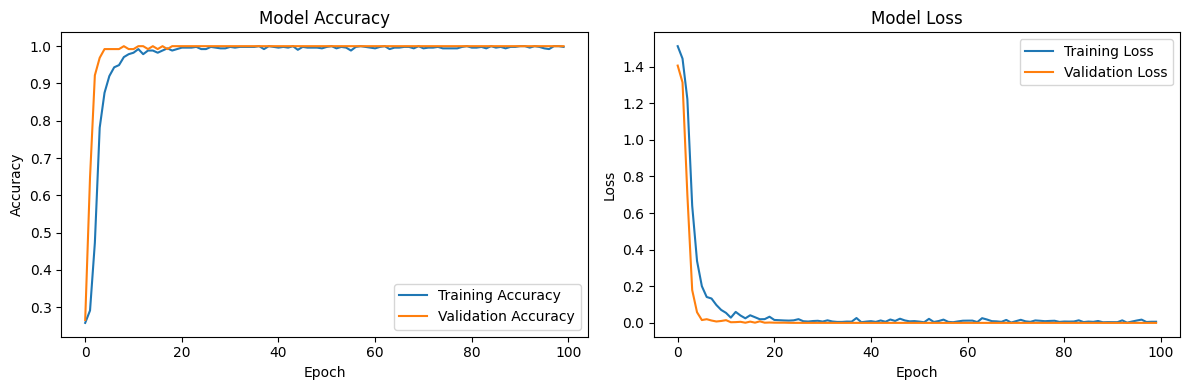

In [12]:
import matplotlib.pyplot as plt

# Assuming `history` is obtained from model.fit()
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
